In [1]:
import os
import sys
import urllib.request
import re
import json
import csv
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
client_id = "6edzCNnNWRuAcEfH4xKc"
client_secret = "T6ZF8xVRNj"
def korean_font():
    plt.rc('font', family='AppleGothic')
    plt.rcParams['axes.unicode_minus'] = False
    

In [5]:
class NaverDataLabOpenAPI():
    
    def __init__(self, client_id, client_secret):
        self.client_id = client_id
        self.client_secret = client_secret
        self.keywordGroups = []
        self.url = "https://openapi.naver.com/v1/datalab/search"

    def add_keyword_groups(self, group_dict):
        keyword_gorup = {
            'groupName': group_dict['groupName'],
            'keywords': group_dict['keywords']
        }        
        self.keywordGroups.append(keyword_gorup)
        print(f">>> Num of keywordGroups: {len(self.keywordGroups)}")
        
    def get_data(self, startDate, endDate, timeUnit, device, ages, gender):
        # 데이터 요청 사항 입력
        body = json.dumps({
            "startDate": startDate,
            "endDate": endDate,
            "timeUnit": timeUnit,
            "keywordGroups": self.keywordGroups,
            "device": device,
            "ages": ages,
            "gender": gender
        }, ensure_ascii=False)
        
        # 불러오기
        request = urllib.request.Request(self.url)
        request.add_header("X-Naver-Client-Id",self.client_id)
        request.add_header("X-Naver-Client-Secret",self.client_secret)
        request.add_header("Content-Type","application/json")
        response = urllib.request.urlopen(request, data=body.encode("utf-8"))
        rescode = response.getcode()
        if(rescode==200):
            # Json Result
            result = json.loads(response.read())
            
            df = pd.DataFrame(result['results'][0]['data'])[['period']]
            for i in range(len(self.keywordGroups)):
                tmp = pd.DataFrame(result['results'][i]['data'])
                tmp = tmp.rename(columns={'ratio': result['results'][i]['title']})
                df = pd.merge(df, tmp, how='left', on=['period'])
            self.df = df.rename(columns={'period': '날짜'})
            self.df['날짜'] = pd.to_datetime(self.df['날짜'])
            
        else:
            print("Error Code:" + rescode)
            
        return self.df
    
    def plot_daily_trend(self):
        colList = self.df.columns[1:]
        n_col = len(colList)

        fig = plt.figure(figsize=(12,6))
        plt.title('일 별 검색어 트렌드', size=20, weight='bold')
        for i in range(n_col):
            sns.lineplot(x=self.df['날짜'], y=self.df[colList[i]], label=colList[i])
        plt.legend(loc='upper right')
        
        return fig
    
    def plot_monthly_trend(self):
        df = self.df.copy()
        df_0 = df.groupby(by=[df['날짜'].dt.year, df['날짜'].dt.month]).mean().droplevel(0).reset_index().rename(columns={'날짜': '월'})
        df_1 = df.groupby(by=[df['날짜'].dt.year, df['날짜'].dt.month]).mean().droplevel(1).reset_index().rename(columns={'날짜': '년도'})

        df = pd.merge(df_1[['년도']], df_0, how='left', left_index=True, right_index=True)
        df['날짜'] = pd.to_datetime(df[['년도','월']].assign(일=1).rename(columns={"년도": "year", "월":'month','일':'day'}))
        
        colList = df.columns.drop(['날짜','년도','월'])
        n_col = len(colList)
                
        fig = plt.figure(figsize=(12,6))
        plt.title('월 별 검색어 트렌드', size=20, weight='bold')
        for i in range(n_col):
            sns.lineplot(x=df['날짜'], y=df[colList[i]], label=colList[i])
        plt.legend(loc='upper right')
        
        return fig

In [6]:
keyword_group_set = {
    'keyword_group_1': {'groupName': "관광", 'keywords': ["관광","명소","부산"]},
    'keyword_group_2': {'groupName': "레저", 'keywords': ["레저","부산"]},
    'keyword_group_3': {'groupName': "숙소", 'keywords': ["숙소","분위기","부산"]},
    'keyword_group_4': {'groupName': "음식점", 'keywords': ["음식점","부산"]},
    'keyword_group_5': {'groupName': "시장", 'keywords': ["시장","부산"]}
}

In [7]:
# API 인증 정보 설정
client_id = "6edzCNnNWRuAcEfH4xKc"
client_secret = "T6ZF8xVRNj"

# 요청 파라미터 설정
startDate = "2019-01-01"
endDate = "2019-12-31"
timeUnit = 'date'
device = ''
ages = []
gender = ''

# 데이터 프레임 정의
naver = NaverDataLabOpenAPI(client_id=client_id, client_secret=client_secret)

naver.add_keyword_groups(keyword_group_set['keyword_group_1'])
naver.add_keyword_groups(keyword_group_set['keyword_group_2'])
naver.add_keyword_groups(keyword_group_set['keyword_group_3'])
naver.add_keyword_groups(keyword_group_set['keyword_group_4'])
naver.add_keyword_groups(keyword_group_set['keyword_group_5'])

df = naver.get_data(startDate, endDate, timeUnit, device, ages, gender)

>>> Num of keywordGroups: 1
>>> Num of keywordGroups: 2
>>> Num of keywordGroups: 3
>>> Num of keywordGroups: 4
>>> Num of keywordGroups: 5


In [8]:
df

,날짜,관광,레저,숙소,음식점,시장
0,2019-01-01,24.80849,23.38488,25.09033,26.27547,25.42997
1,2019-01-02,26.46336,24.84101,27.12097,26.70183,26.15623
2,2019-01-03,26.19959,24.66758,26.57898,26.52478,26.03338
3,2019-01-04,25.20595,23.78956,25.76961,25.88524,25.10117
4,2019-01-05,24.08585,22.94768,24.75791,25.58173,24.64590
...,...,...,...,...,...,...
360,2019-12-27,28.28443,27.68824,29.87787,30.25726,28.85893
361,2019-12-28,27.85807,27.14265,29.40453,30.34759,29.11909
362,2019-12-29,27.65573,27.07399,29.05405,30.02601,28.91675
363,2019-12-30,36.29137,35.56149,37.53071,38.20638,36.69966


In [9]:
df.columns[1:]

Index(['관광', '레저', '숙소', '음식점', '시장'], dtype='object')

In [10]:
df.head()

,날짜,관광,레저,숙소,음식점,시장
0,2019-01-01,24.80849,23.38488,25.09033,26.27547,25.42997
1,2019-01-02,26.46336,24.84101,27.12097,26.70183,26.15623
2,2019-01-03,26.19959,24.66758,26.57898,26.52478,26.03338
3,2019-01-04,25.20595,23.78956,25.76961,25.88524,25.10117
4,2019-01-05,24.08585,22.94768,24.75791,25.58173,24.64590


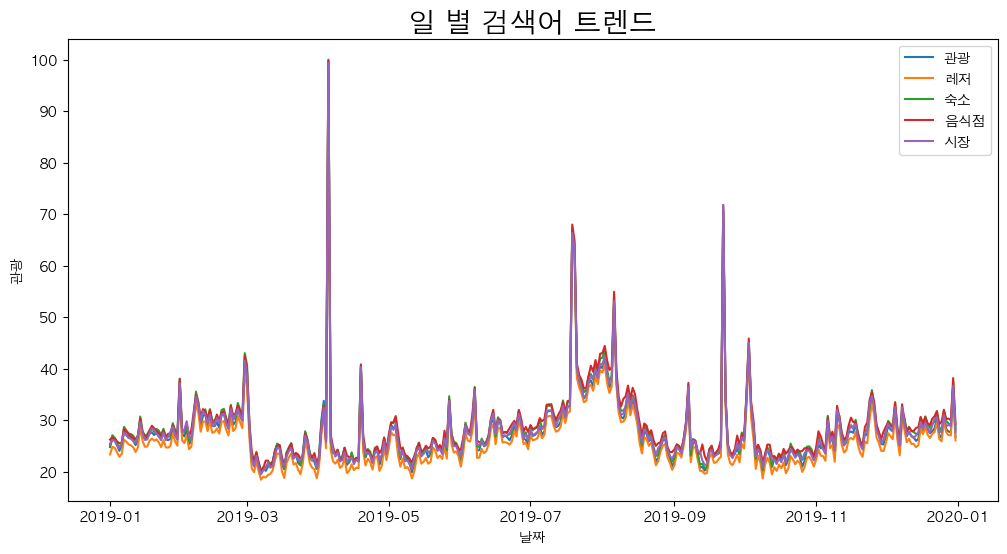

In [11]:
korean_font()
fig_1 = naver.plot_daily_trend()

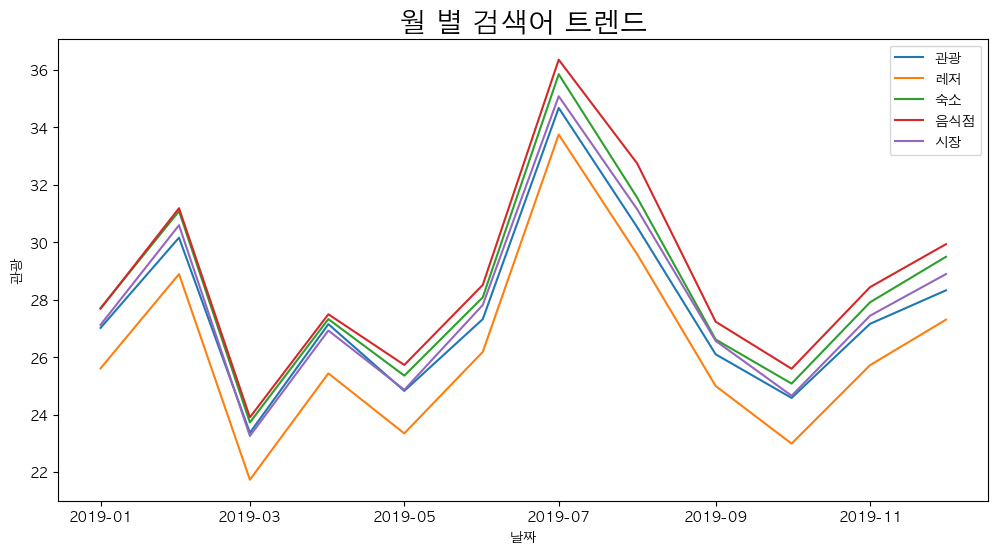

In [12]:
fig_2 = naver.plot_monthly_trend()